# Lab Two: Classification

We will build upon the predictive analysis (classification) that we completed in the
previous mini-project, adding additional modeling from new classification algorithms as well as
more explanations that are inline with the CRISP-DM framework.

We chose to continue to use the CIFAR-10 dataset. We identified the two tasks from the dataset to classify. 
Task 1: Cats and dogs
Task 2: Birds and airplanes


By Martin Garcia, Joanna Duran, Daniel Byrne

## Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random
import time
import sklearn.naive_bayes as b
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import convolve


from sklearn.linear_model import SGDClassifier
from sklearn.utils import compute_class_weight

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Summary of Minilab

### Business Understanding
Our objective was to create a logistic regression model and a support vector machine model for the classification of each image. We were to determine which model is best suited for this standard classification task based on a comparison on their prediction accuracy, training times, and computational efficiency.

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6,000 images per class.

### Data Meaning Type

#### The CIFAR-10 dataset
We are using the [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset which consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. The dataset includes are 50,000(80%) training images and 10,000(20%) test images broken in to 5 pre-randomized training batches and 1 test batch.

Each training batch contains 10,000 observations with a row vector of length 3,072 representative of color image of 32x32 pixels. The first 1,024 columns consist of red values, followed by green, and blue. The data also incorporates labels ranging from 0 to 9 and are listed below.

* airplane : 0
* automobile : 1
* bird : 2
* cat : 3
* deer : 4
* dog : 5
* frog : 6
* horse : 7
* ship : 8
* truck : 9

The test batch contains 1,000 randomly-selected images from each class. The 5 training batches are randomized and contain a variable number of images from each class. 

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

#### Simple Statistics

In [2]:
#load the data, reshape to 32x32 matrix per color, transpose matrices
def load_cfar10_batch(path, batch_id = None, reshape = True):
    """
    Argument:
    path -- path the datasets
    batch_id -- id of the batch (1 to 5) to load
    
    Returns:
    parameters -- python dictionary containing:
                    X -- features
                    Y -- labels
    """
    if batch_id is not None:
        filepath = path + 'data_batch_' + str(batch_id)
    else:
        filepath = path
        
    with open(filepath, mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
    
    if reshape:    
        X = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
        Y = np.array(batch['labels'])
    else:
        X = batch['data']
        Y = np.array(batch['labels'])
        
    return X, Y

In [3]:
def load_cfar10_dataset():
    """
    Loads the cfar10 dataset
    
    Arguments: 
        None
    
    Returns:
        X - Training dataset
        Y - Training labels
         - Test datset
        y_test - test labelss
    """
    x_test,y_test = load_cfar10_batch("data/test_batch",None,False)
    X,Y = load_cfar10_batch("data/",1,False)

    for n in range(2,6):
        x,y = load_cfar10_batch("data/",n,False)    
        X = np.concatenate((X,x),axis=0)
        Y = np.concatenate((Y,y),axis=0)


    return (X,Y,x_test,y_test)


Stats of batch #4:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 1003
Label Counts of [1](AUTOMOBILE) : 963
Label Counts of [2](BIRD) : 1041
Label Counts of [3](CAT) : 976
Label Counts of [4](DEER) : 1004
Label Counts of [5](DOG) : 1021
Label Counts of [6](FROG) : 1004
Label Counts of [7](HORSE) : 981
Label Counts of [8](SHIP) : 1024
Label Counts of [9](TRUCK) : 983

Example of Image 5235:
Image - Min Value: 2 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


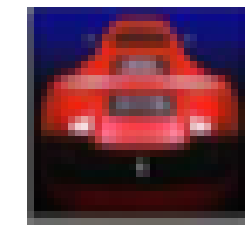

In [4]:
#load labels for our label
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#display images
def display_stats(data, batch_id, sample_id):
    features, labels = load_cfar10_batch(data, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))

    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)

batch_id = random.randint(1,5)
sample_id = random.randint(1,10000)
display_stats( "data/", batch_id, sample_id)

## Data Preparation Part 1

In this section we will define and prepare our class variables. 

Each of the batch files contains a dictionary with the following elements: 

data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image. 

labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries: 

label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

"Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis."

In [5]:
def simplify_labels(df,indexes,val = 10):
    """
    Return a modified label dataset filtered ot use only the classes specified

    Arguments:
    indees: indexes to filter
    df : label dataset
    val: new label value

    Returns:
    fdf - filtered df
      
    """

    def f(n):
        if n in indexes:
            return n
        else:
            return val
    
    return np.array(list(map(f,df)))


In [6]:
def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 32x32 images in X around by 1px to left, right, down, up.
    
    
    """
    direction_vectors = np.array([
        [[[0, 1, 0],
          [0, 0, 0],
          [0, 0, 0]]],

        [[[0, 0, 0],
          [1, 0, 0],
          [0, 0, 0]]],

        [[[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]]],

        [[[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]
    ])
    
    def shift(x, w):
        c = convolve(x.reshape((3,32,32)), mode='constant', weights=w).ravel()
        return c

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

In [7]:
#load the data
X,Y,x_test,y_test = load_cfar10_dataset()


# In order to learn good latent representations from a small dataset, 
# we artificially generate more labeled data by perturbing the training
# data with linear shifts of 1 pixel in each direction.
X, Y = nudge_dataset(X, Y)
x_test, y_test = nudge_dataset(x_test, y_test)

# Simplify label datasets to only the classes we care about
Ycatdog = simplify_labels(Y,[3,5],10)
y_test_catdog =simplify_labels(y_test,[3,5],10)
Ybirdplane = simplify_labels(Y,[0,2],10)
y_test_birdplane = simplify_labels(y_test,[0,2],10)

## Data Preparation Part 2

### Label Reduction

The final training dataset is identical to the original.  However, we've created 4 new label datasets targeting the labels we want our models to classify

- Ycatdog, y_test_catdog  : Cat and dog labels are retained, all others forced to next unused label
- Ybirdplane,y_test_birdplane : Bird and plane  labels are retained, all others forced to next unused label

### Artificial Data Augmentation

In order to learn good latent representations from a small dataset, 
we artificially generate more labeled data by perturbing the training
data with linear shifts of 1 pixel in each direction.

Other augmentations such as color shifting, rotation and cropping are useful and often used as well in preparing image data for deeplearning tasks.

In [8]:
def plti(im, h=2, **kwargs):
    """
    Helper function to plot an image.
    """
    y = im.shape[0]
    x = im.shape[1]
    w = (y/x) * h
    plt.figure(figsize=(w,h))
    plt.imshow(im, interpolation="none", **kwargs)
    plt.axis('off')

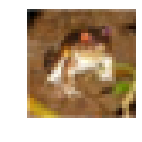

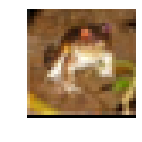

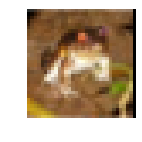

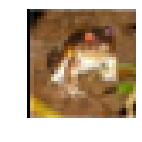

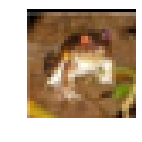

In [ ]:
# plot augmented images

plti(X[0].reshape((3,32,32)).transpose(1,2,0))
plti(X[50000].reshape((3,32,32)).transpose(1,2,0))
plti(X[100000].reshape((3,32,32)).transpose(1,2,0))
plti(X[150000].reshape((3,32,32)).transpose(1,2,0))
plti(X[200000].reshape((3,32,32)).transpose(1,2,0))

In [ ]:
print("Augmented Data shape: ",X.shape)
print("Augmented Labels shape: ",Ycatdog.shape)

print("Augmented Test Data shape: ",x_test.shape)
print("Augmented Test Labels shape: ",y_test_catdog.shape)

Augmented Data shape:  (250000, 3072)
Augmented Labels shape:  (250000,)
Augmented Test Data shape:  (50000, 3072)
Augmented Test Labels shape:  (50000,)


### Data Scaling

Multi-layer Perceptrons are sensitive to feature scaling, so sklearn highly recommendeds scaling the data.  The same scaling must be applied to the test set for meaningful results.

In [ ]:
### Data Scaling

from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X)  
Xmlp = scaler.transform(X)  
x_testmlp = scaler.transform(x_test) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Modeling and Evaluation 1

Using machine learning to detect and classify images is becoming a very common occurrence. It is being used for the detection of oil spills in satellite radar images as well as gender classification on real-world face images. 

For our project we will classify images into 10 classes. Since this is a large number of classes, overall accuracy is a definite concern. We want to ensure that the number of false positives are low. Another factor that influences the number of false positives/ negatives is if the classes are not balanced. For our data set this is not a concern because our ten classes each have the same number of samples.

"Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions."

## Modeling and Evaluation 2

 We will assess how well each model performs (use 80/20 training/testing split)and adjust parameters of the models to make them more accurate. 


"Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time."

## Modeling and Evaluation 3

We identified the two tasks from the dataset to classify. For each task we will create three different classification/regression models

Task 1: Cats and dogs

    Model A: Naive Bayes
    Model B: Multi-layer Perceptron classifier (MLP)
    Model C: Support Vector Machine (SVM)
    
Task 2: Birds and airplanes

    Model A: Naive Bayes
    Model B: Decision Tree
    Model C: SVM

"Create three different classiﬁcation/regression models (e.g., random forest, KNN, and SVM). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric"


### Task 1 Model A
Cats and Dogs- Naive Bayes, Multi-layer Perceptron classifier and Support Vector Machine
    
We chose several implementations of the Naive Bayes classifier: GaussianNB, MultinomialNB, and BernoulliNB.


In [ ]:
def buildmodel(nmodel,X,Y,x_test,y_test,**modelargs):
    """
    Builds one of a subset of sklearn models and returns a score
    
    Arguments:
    modeltype -- One of either "multi", "gauss", "bernoulli", "c", "nn" 
    
    """

    if nmodel == 'multi':
        m = b.MultinomialNB(**modelargs)
    elif nmodel == 'gauss':
        m = b.GaussianNB(**modelargs)
    elif nmodel == 'bernoulli':
        m = b.BernoulliNB(**modelargs)
    elif nmodel == "mlp":
        m = MLPClassifier(**modelargs)
    elif nmodel == "svm":
        m = SGDClassifier(**modelargs)
    elif nmodel == "BernoulliRBM":
        m = BernoulliRBM(**modelargs)
    elif nmodel == "LogisticRegression":
        m = LogisticRegression(**modelargs)
    
    m.fit(X, Y)
    score = m.score(x_test,y_test) * 100

    return m,score

In [ ]:
berboulliNB, bernoulliNBScore = buildmodel('bernoulli',X,Ycatdog,x_test,y_test_catdog,alpha = .01)
print("BernoulliNB score :%",round(bernoulliNBScore,2))

BernoulliNB score :% 77.11


In [ ]:
mlp, mlpScore = buildmodel('mlp',Xmlp,Ycatdog,x_testmlp,y_test_catdog,
                           activation = 'relu',hidden_layer_sizes=(10,),learning_rate ='adaptive',verbose = True, tol = .001,
                           max_iter = 50, n_iter_no_change =5)
print("Multi-layer Perceptron score :%",round(mlpScore,2))

Iteration 1, loss = 0.55540982
Iteration 2, loss = 0.48965374
Iteration 3, loss = 0.47411030
Iteration 4, loss = 0.46777918
Iteration 5, loss = 0.46319362
Iteration 6, loss = 0.45959056
Iteration 7, loss = 0.45735656
Iteration 8, loss = 0.45467369
Iteration 9, loss = 0.45267992
Iteration 10, loss = 0.45062179
Iteration 11, loss = 0.44867539
Iteration 12, loss = 0.44809624
Iteration 13, loss = 0.44678363
Iteration 14, loss = 0.44484739
Iteration 15, loss = 0.44373537
Iteration 16, loss = 0.44330410
Iteration 17, loss = 0.44198703
Iteration 18, loss = 0.44084836
Iteration 19, loss = 0.44063666
Iteration 20, loss = 0.43969698
Iteration 21, loss = 0.43916001
Iteration 22, loss = 0.43794461
Iteration 23, loss = 0.43733903
Iteration 24, loss = 0.43702245
Iteration 25, loss = 0.43688401
Iteration 26, loss = 0.43543648
Iteration 27, loss = 0.43493762
Iteration 28, loss = 0.43503960
Iteration 29, loss = 0.43450510
Iteration 30, loss = 0.43435107
Iteration 31, loss = 0.43348169
Iteration 32, los

In [ ]:
svm, svmScore = buildmodel('svm',Xmlp,Ycatdog,x_testmlp,y_test_catdog,alpha=0.001, max_iter=500, 
                           tol=.01,verbose=1,n_jobs=4,loss="log",n_iter_no_change =5)
print("svmScore score :%",round(svmScore,2))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


-- Epoch 1-- Epoch 1
-- Epoch 1

Norm: 27.07, NNZs: 3072, Bias: 130.060532, T: 250000, Avg. loss: 34.974994
Total training time: 2.21 seconds.
-- Epoch 2
Norm: 43.89, NNZs: 3072, Bias: -470.710591, T: 250000, Avg. loss: 38.039267
Total training time: 2.66 seconds.
-- Epoch 2
Norm: 47.16, NNZs: 3072, Bias: -466.576966, T: 250000, Avg. loss: 40.663918
Total training time: 2.76 seconds.
-- Epoch 2
Norm: 15.90, NNZs: 3072, Bias: 53.172496, T: 500000, Avg. loss: 10.383192
Total training time: 4.28 seconds.
-- Epoch 3
Norm: 40.62, NNZs: 3072, Bias: -427.050795, T: 500000, Avg. loss: 27.027816
Total training time: 5.36 seconds.
-- Epoch 3
Norm: 44.73, NNZs: 3072, Bias: -418.679253, T: 500000, Avg. loss: 28.896995
Total training time: 5.41 seconds.
-- Epoch 3
Norm: 7.61, NNZs: 3072, Bias: 12.249395, T: 750000, Avg. loss: 3.756211
Total training time: 6.32 seconds.
-- Epoch 4
Norm: 43.08, NNZs: 3072, Bias: -390.768627, T: 750000, Avg. loss: 26.380927
Total training time: 8.01 seconds.
-- Epoch 

Norm: 30.93, NNZs: 3072, Bias: -238.652882, T: 7000000, Avg. loss: 15.402875
Total training time: 61.00 seconds.
-- Epoch 29
Norm: 29.37, NNZs: 3072, Bias: -264.149772, T: 6750000, Avg. loss: 15.757735
Total training time: 61.26 seconds.
-- Epoch 28
Norm: 30.74, NNZs: 3072, Bias: -236.288833, T: 7250000, Avg. loss: 15.246083
Total training time: 62.95 seconds.
-- Epoch 30
Norm: 29.30, NNZs: 3072, Bias: -261.883726, T: 7000000, Avg. loss: 15.618915
Total training time: 63.24 seconds.
-- Epoch 29
Norm: 30.55, NNZs: 3072, Bias: -234.006215, T: 7500000, Avg. loss: 15.092793
Total training time: 64.94 seconds.
-- Epoch 31
Norm: 29.08, NNZs: 3072, Bias: -259.714015, T: 7250000, Avg. loss: 15.481117
Total training time: 65.22 seconds.
-- Epoch 30
Norm: 30.34, NNZs: 3072, Bias: -231.802151, T: 7750000, Avg. loss: 14.944569
Total training time: 66.87 seconds.
-- Epoch 32
Norm: 28.88, NNZs: 3072, Bias: -257.616454, T: 7500000, Avg. loss: 15.353955
Total training time: 67.20 seconds.
-- Epoch 31


Norm: 26.21, NNZs: 3072, Bias: -186.486059, T: 15250000, Avg. loss: 11.953276
Total training time: 125.94 seconds.
-- Epoch 62
Norm: 25.73, NNZs: 3072, Bias: -214.770904, T: 15000000, Avg. loss: 12.734595
Total training time: 126.69 seconds.
-- Epoch 61
Norm: 26.13, NNZs: 3072, Bias: -185.399902, T: 15500000, Avg. loss: 11.884403
Total training time: 127.92 seconds.
-- Epoch 63
Norm: 25.66, NNZs: 3072, Bias: -213.751353, T: 15250000, Avg. loss: 12.673111
Total training time: 128.69 seconds.
-- Epoch 62
Norm: 26.00, NNZs: 3072, Bias: -184.337607, T: 15750000, Avg. loss: 11.810502
Total training time: 129.90 seconds.
-- Epoch 64
Norm: 25.59, NNZs: 3072, Bias: -212.749401, T: 15500000, Avg. loss: 12.612642
Total training time: 130.67 seconds.
-- Epoch 63
Norm: 25.93, NNZs: 3072, Bias: -183.284931, T: 16000000, Avg. loss: 11.744735
Total training time: 131.89 seconds.
-- Epoch 65
Norm: 25.49, NNZs: 3072, Bias: -211.766848, T: 15750000, Avg. loss: 12.552382
Total training time: 132.69 secon

Norm: 23.67, NNZs: 3072, Bias: -188.500237, T: 23000000, Avg. loss: 11.144931
Total training time: 189.45 seconds.
-- Epoch 93
Norm: 23.45, NNZs: 3072, Bias: -157.768240, T: 23500000, Avg. loss: 10.077491
Total training time: 190.57 seconds.
-- Epoch 95
Norm: 23.62, NNZs: 3072, Bias: -187.837003, T: 23250000, Avg. loss: 11.104460
Total training time: 191.42 seconds.
-- Epoch 94
Norm: 23.38, NNZs: 3072, Bias: -157.068190, T: 23750000, Avg. loss: 10.032574
Total training time: 192.52 seconds.
-- Epoch 96
Norm: 23.58, NNZs: 3072, Bias: -187.179764, T: 23500000, Avg. loss: 11.064919
Total training time: 193.40 seconds.
-- Epoch 95
Norm: 23.32, NNZs: 3072, Bias: -156.374294, T: 24000000, Avg. loss: 9.985727
Total training time: 194.56 seconds.
-- Epoch 97
Norm: 23.51, NNZs: 3072, Bias: -186.532550, T: 23750000, Avg. loss: 11.026457
Total training time: 195.45 seconds.
-- Epoch 96
Norm: 23.25, NNZs: 3072, Bias: -155.690253, T: 24250000, Avg. loss: 9.943172
Total training time: 196.58 seconds

Norm: 21.52, NNZs: 3072, Bias: -138.427934, T: 31500000, Avg. loss: 8.821280
Total training time: 254.31 seconds.
-- Epoch 127
Norm: 22.14, NNZs: 3072, Bias: -169.739757, T: 31250000, Avg. loss: 10.015371
Total training time: 255.60 seconds.
-- Epoch 126
Norm: 21.46, NNZs: 3072, Bias: -137.908366, T: 31750000, Avg. loss: 8.787205
Total training time: 256.24 seconds.
-- Epoch 128
Norm: 22.09, NNZs: 3072, Bias: -169.253663, T: 31500000, Avg. loss: 9.985869
Total training time: 257.60 seconds.
-- Epoch 127
Norm: 21.41, NNZs: 3072, Bias: -137.392207, T: 32000000, Avg. loss: 8.754508
Total training time: 258.20 seconds.
-- Epoch 129
Norm: 22.06, NNZs: 3072, Bias: -168.770076, T: 31750000, Avg. loss: 9.956840
Total training time: 259.64 seconds.
-- Epoch 128
Norm: 21.37, NNZs: 3072, Bias: -136.879058, T: 32250000, Avg. loss: 8.720914
Total training time: 260.25 seconds.
-- Epoch 130
Norm: 22.01, NNZs: 3072, Bias: -168.291673, T: 32000000, Avg. loss: 9.927394
Total training time: 261.69 secon

Norm: 20.97, NNZs: 3072, Bias: -155.836185, T: 39250000, Avg. loss: 9.179733
Total training time: 319.47 seconds.
-- Epoch 158
Norm: 19.95, NNZs: 3072, Bias: -123.146567, T: 39750000, Avg. loss: 7.832482
Total training time: 319.64 seconds.
-- Epoch 160
Norm: 20.94, NNZs: 3072, Bias: -155.448434, T: 39500000, Avg. loss: 9.157327
Total training time: 321.55 seconds.
-- Epoch 159
Norm: 19.90, NNZs: 3072, Bias: -122.736878, T: 40000000, Avg. loss: 7.806032
Total training time: 321.73 seconds.
-- Epoch 161
Norm: 20.91, NNZs: 3072, Bias: -155.064610, T: 39750000, Avg. loss: 9.133805
Total training time: 323.60 seconds.
-- Epoch 160
Norm: 19.86, NNZs: 3072, Bias: -122.328797, T: 40250000, Avg. loss: 7.779494
Total training time: 323.82 seconds.
-- Epoch 162
Norm: 20.88, NNZs: 3072, Bias: -154.682201, T: 40000000, Avg. loss: 9.111251
Total training time: 325.78 seconds.
-- Epoch 161
Norm: 19.82, NNZs: 3072, Bias: -121.922868, T: 40500000, Avg. loss: 7.753394
Total training time: 325.94 second

Norm: 19.98, NNZs: 3072, Bias: -144.229625, T: 47500000, Avg. loss: 8.485773
Total training time: 385.28 seconds.
-- Epoch 191
Norm: 18.64, NNZs: 3072, Bias: -110.811705, T: 48000000, Avg. loss: 7.036258
Total training time: 385.32 seconds.
-- Epoch 193
Norm: 19.95, NNZs: 3072, Bias: -143.911374, T: 47750000, Avg. loss: 8.466621
Total training time: 387.25 seconds.
-- Epoch 192
Norm: 18.60, NNZs: 3072, Bias: -110.474151, T: 48250000, Avg. loss: 7.014400
Total training time: 387.31 seconds.
-- Epoch 194
Norm: 19.92, NNZs: 3072, Bias: -143.594082, T: 48000000, Avg. loss: 8.447329
Total training time: 389.16 seconds.
-- Epoch 193
Norm: 18.57, NNZs: 3072, Bias: -110.135815, T: 48500000, Avg. loss: 6.992822
Total training time: 389.25 seconds.
-- Epoch 195
Norm: 19.89, NNZs: 3072, Bias: -143.278513, T: 48250000, Avg. loss: 8.428638
Total training time: 391.10 seconds.
-- Epoch 194
Norm: 18.53, NNZs: 3072, Bias: -109.800518, T: 48750000, Avg. loss: 6.970836
Total training time: 391.21 second

Norm: 19.14, NNZs: 3072, Bias: -134.786434, T: 55500000, Avg. loss: 7.921223
Total training time: 448.52 seconds.
-- Epoch 223
Norm: 17.52, NNZs: 3072, Bias: -100.477658, T: 56250000, Avg. loss: 6.371024
Total training time: 450.26 seconds.
-- Epoch 226
Norm: 19.12, NNZs: 3072, Bias: -134.513626, T: 55750000, Avg. loss: 7.905293
Total training time: 450.47 seconds.
-- Epoch 224
Norm: 17.49, NNZs: 3072, Bias: -100.188888, T: 56500000, Avg. loss: 6.352596
Total training time: 452.22 seconds.
-- Epoch 227
Norm: 19.09, NNZs: 3072, Bias: -134.242371, T: 56000000, Avg. loss: 7.888846
Total training time: 452.41 seconds.
-- Epoch 225
Norm: 17.46, NNZs: 3072, Bias: -99.902067, T: 56750000, Avg. loss: 6.334008
Total training time: 454.21 seconds.
-- Epoch 228
Norm: 19.07, NNZs: 3072, Bias: -133.972409, T: 56250000, Avg. loss: 7.872701
Total training time: 454.40 seconds.
-- Epoch 226
Norm: 17.42, NNZs: 3072, Bias: -99.616765, T: 57000000, Avg. loss: 6.316025
Total training time: 456.17 seconds.

Norm: 16.56, NNZs: 3072, Bias: -91.844555, T: 64250000, Avg. loss: 5.816639
Total training time: 513.86 seconds.
-- Epoch 258
Norm: 18.38, NNZs: 3072, Bias: -126.397471, T: 63750000, Avg. loss: 7.421468
Total training time: 514.17 seconds.
-- Epoch 256
Norm: 16.53, NNZs: 3072, Bias: -91.593151, T: 64500000, Avg. loss: 5.800555
Total training time: 515.84 seconds.
-- Epoch 259
Norm: 18.36, NNZs: 3072, Bias: -126.160267, T: 64000000, Avg. loss: 7.407402
Total training time: 516.11 seconds.
-- Epoch 257
Norm: 16.50, NNZs: 3072, Bias: -91.342079, T: 64750000, Avg. loss: 5.784277
Total training time: 517.76 seconds.
-- Epoch 260
Norm: 18.33, NNZs: 3072, Bias: -125.924855, T: 64250000, Avg. loss: 7.393117
Total training time: 518.06 seconds.
-- Epoch 258
Norm: 16.47, NNZs: 3072, Bias: -91.092218, T: 65000000, Avg. loss: 5.768465
Total training time: 519.73 seconds.
-- Epoch 261
Norm: 18.30, NNZs: 3072, Bias: -125.691367, T: 64500000, Avg. loss: 7.378705
Total training time: 520.00 seconds.
-

Norm: 17.71, NNZs: 3072, Bias: -119.256792, T: 71750000, Avg. loss: 6.996467
Total training time: 579.51 seconds.
-- Epoch 288
Norm: 15.66, NNZs: 3072, Bias: -84.027727, T: 72500000, Avg. loss: 5.315650
Total training time: 580.91 seconds.
-- Epoch 291
Norm: 17.69, NNZs: 3072, Bias: -119.046802, T: 72000000, Avg. loss: 6.983870
Total training time: 581.50 seconds.
-- Epoch 289
Norm: 15.64, NNZs: 3072, Bias: -83.804921, T: 72750000, Avg. loss: 5.301417
Total training time: 582.92 seconds.
-- Epoch 292
Norm: 17.67, NNZs: 3072, Bias: -118.837456, T: 72250000, Avg. loss: 6.971006
Total training time: 583.51 seconds.
-- Epoch 290
Norm: 15.62, NNZs: 3072, Bias: -83.583404, T: 73000000, Avg. loss: 5.287332
Total training time: 584.95 seconds.
-- Epoch 293
Norm: 17.65, NNZs: 3072, Bias: -118.629644, T: 72500000, Avg. loss: 6.958907
Total training time: 585.53 seconds.
-- Epoch 291
Norm: 15.59, NNZs: 3072, Bias: -83.362600, T: 73250000, Avg. loss: 5.272884
Total training time: 586.94 seconds.
-

Norm: 14.88, NNZs: 3072, Bias: -77.277117, T: 80500000, Avg. loss: 4.883780
Total training time: 644.48 seconds.
-- Epoch 323
Norm: 17.08, NNZs: 3072, Bias: -112.696652, T: 80000000, Avg. loss: 6.606433
Total training time: 645.47 seconds.
-- Epoch 321
Norm: 14.86, NNZs: 3072, Bias: -77.076729, T: 80750000, Avg. loss: 4.870874
Total training time: 646.43 seconds.
-- Epoch 324
Norm: 17.07, NNZs: 3072, Bias: -112.508240, T: 80250000, Avg. loss: 6.595263
Total training time: 647.47 seconds.
-- Epoch 322
Norm: 14.83, NNZs: 3072, Bias: -76.878329, T: 81000000, Avg. loss: 4.858168
Total training time: 648.52 seconds.
-- Epoch 325
Norm: 17.05, NNZs: 3072, Bias: -112.321096, T: 80500000, Avg. loss: 6.583855
Total training time: 649.58 seconds.
-- Epoch 323
Norm: 14.81, NNZs: 3072, Bias: -76.679514, T: 81250000, Avg. loss: 4.845669
Total training time: 650.61 seconds.
-- Epoch 326
Norm: 17.04, NNZs: 3072, Bias: -112.133872, T: 80750000, Avg. loss: 6.573008
Total training time: 651.61 seconds.
-

Norm: 16.53, NNZs: 3072, Bias: -106.961818, T: 88000000, Avg. loss: 6.266032
Total training time: 713.58 seconds.
-- Epoch 353
Norm: 14.13, NNZs: 3072, Bias: -71.004067, T: 88750000, Avg. loss: 4.483196
Total training time: 714.56 seconds.
-- Epoch 356
Norm: 16.51, NNZs: 3072, Bias: -106.791637, T: 88250000, Avg. loss: 6.255889
Total training time: 715.76 seconds.
-- Epoch 354
Norm: 14.11, NNZs: 3072, Bias: -70.823944, T: 89000000, Avg. loss: 4.471569
Total training time: 716.72 seconds.
-- Epoch 357
Norm: 16.50, NNZs: 3072, Bias: -106.621083, T: 88500000, Avg. loss: 6.245751
Total training time: 717.94 seconds.
-- Epoch 355
Norm: 14.09, NNZs: 3072, Bias: -70.643535, T: 89250000, Avg. loss: 4.460144
Total training time: 718.89 seconds.
-- Epoch 358
Norm: 16.48, NNZs: 3072, Bias: -106.451560, T: 88750000, Avg. loss: 6.235641
Total training time: 720.14 seconds.
-- Epoch 356
Norm: 14.06, NNZs: 3072, Bias: -70.464062, T: 89500000, Avg. loss: 4.448591
Total training time: 721.06 seconds.
-

Norm: 13.17, NNZs: 3072, Bias: -63.201447, T: 100250000, Avg. loss: 3.985762
Total training time: 814.44 seconds.
-- Epoch 402
Norm: 13.15, NNZs: 3072, Bias: -63.041904, T: 100500000, Avg. loss: 3.975641
Total training time: 816.59 seconds.
-- Epoch 403
Norm: 13.13, NNZs: 3072, Bias: -62.883727, T: 100750000, Avg. loss: 3.965406
Total training time: 818.73 seconds.
-- Epoch 404
Norm: 13.11, NNZs: 3072, Bias: -62.724748, T: 101000000, Avg. loss: 3.955441
Total training time: 820.88 seconds.
-- Epoch 405
Norm: 13.09, NNZs: 3072, Bias: -62.567044, T: 101250000, Avg. loss: 3.945362
Total training time: 823.07 seconds.
-- Epoch 406
Norm: 13.07, NNZs: 3072, Bias: -62.409078, T: 101500000, Avg. loss: 3.935182
Total training time: 825.14 seconds.
-- Epoch 407
Norm: 13.05, NNZs: 3072, Bias: -62.253301, T: 101750000, Avg. loss: 3.925203
Total training time: 827.21 seconds.
-- Epoch 408
Norm: 13.03, NNZs: 3072, Bias: -62.096070, T: 102000000, Avg. loss: 3.915525
Total training time: 829.31 second

[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed: 14.1min finished


svmScore score :% 79.84


For the Naive Bayes model, while MultinomialNB and GaussianNB scores were relatively similar(54.28% and 54.31%, respectively), BernoulliNB  was higher at 77.17%.  
The Multi-layer Perceptron classifier resulted in 80% which surpasses Naive Bayes.
The Support Vector Machine returned a 79.7%.
Being that BernoulliNB, Multi-layer Perceptron classifier and Support Vector Machine are all very similar in score, other factors will be taken into consideration when finding the optimal model.

### Task2 Model A
(Birds and Airplanes- Naive Bayes)

### Task2 Model B
(Birds and Airplanes- Decision Tree)

### Task2 Model C
(Birds and Airplanes- SVM)

## Modeling and Evaluation 4

"Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model."

## Modeling and Evaluation 5

Advantages of Task 1: Cats and dogs Model A: Naive Bayes

    *
Advantages of Task 1: Cats and dogsModel B: Multi-layer Perceptron classifier (MLP)

    *
Advantages of Task 1: Cats and dogsModel C: Support Vector Machine (SVM)

    *
Advantages of Task 2: Birds and airplanes Model A: Naive Bayes

    *
Advantages of Task 2: Birds and airplanes Model B: Decision Tree

    *
Advantages of Task 2: Birds and airplanes Model C: SVM

    *

"Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course."

## Modeling and Evaluation 6

 Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classiﬁcation task. Attributes are pixels representing a range of values 0-255 for each pixel. Together they represent a coefficients or loadings that together build an image. 

In [ ]:
#Range of values in our elements
np.min(X),np.max(X)

(0, 255)

In [ ]:
#We scale the data due to large ranges in values from 0-255
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X)
# Apply transform to both the training set
X_trans = scaler.transform(X)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [ ]:
#new scaled range
np.min(X_trans),np.max(X_trans)

In [ ]:
# We add attribute names to each of our columns
feat_cols = ['pixel '+str(i) for i in range(X_trans.shape[1])]
#Create dataframe for our scaled elements and incorporate column names
df_cifar = pd.DataFrame(X_trans,columns=feat_cols)
df_cifar['label'] = Y
#preview 
df_cifar.head()

In [ ]:
#break into two new components, prin1 and prin2
pca_cifar = PCA(n_components=2)
principalComponents_cifar = pca_cifar.fit_transform(X_trans)

In [ ]:
#add labels
principal_cifar_Df = pd.DataFrame(data = principalComponents_cifar
             , columns = ['prin 1', 'prin 2'])
principal_cifar_Df['y'] = Y

In [ ]:
#percentage of variance explained
print('Explained variation per principal component: {}'.format(pca_cifar.explained_variance_ratio_))

In [ ]:
principal_cifar_Df.head()

## Deployment

We believe that our model would be best suited for

"How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?"

#### OLD- MAY DELETE -Logistic Regression Model

In [ ]:
# Build Logistic Regression Model with Stochastic Gradient Descent 
X,Y = load_cfar10_batch("data/",1,False)

for n in range(2,6):
    x,y = load_cfar10_batch("data/",n,False)    
    X = np.concatenate((X,x),axis=0)
    Y = np.concatenate((Y,y),axis=0)

test_X,test_Y = load_cfar10_batch("data/test_batch",None,False)

# Modify the dataset labels to lable cats/not/cats
#(if_test_is_false, if_test_is_true)[test]
catY = (Y == 3)
cat_test_Y = (test_Y == 3) 

sgdlr = SGDClassifier(alpha=0.001, max_iter=5000, tol=1e-3,verbose=1,n_jobs=4,loss="log")

print("Data shape: ",X.shape)
print("Labels shape: ",catY.shape)

print("Test Data shape: ",test_X.shape)
print("Test Labels shape: ",cat_test_Y.shape)


In [ ]:
import time

start = time.time()
sgdlr.fit(X,catY)
end = time.time()
elapsed = end - start
print("Training complete.  Time elapsed = ",elapsed)

In [ ]:
sgdlrscore = sgdlr.score(test_X,cat_test_Y)
print("Logistic Regression Accuracy: ",sgdlrscore)

#### OLD- MAY DELETE -Model Comparison

The two models were trained with similar hyperparameters to simplify the A/B comparison between the two models.  The only parameter that varied between the two models was the *loss* parameter. 

The loss function defaults to ‘hinge’, which gives a linear SVM. The ‘log’ loss gives logistic regression, a probabilistic classifier. 

The two models we cerated in identifying cats peformed similarly in terms of accuracy, 85% to 89% accuaracy over several test runs.

Training times varied depending on the underlying hardware and computer workload; however, the two models were comparable in overall training times on this dataset 69-72 seconds on Intel Core i7-6700 @ 3.4GHz, 24Gb of RAM, 4 Cores, and and NVIDIA 1060. 

Both models also seemed to mislabel similar images as evident in the plots above.  Both models seemed to struggle with cats in odd, off center poses, or curled up into a ball.  The one car image that was mislabaled as a cat kind of resemebles a cat with the openned hatchback of the car resembling a tail.

Overall both models performed similarily in this classification task with the chosen model parameters.